In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.tree import DecisionTreeRegressor # 분석 알고리즘 DecisionTree 구현 라이브러리
from sklearn.linear_model import LinearRegression # 변동성이 약한 데이터에서는 강한 모습을 보인다.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # 과거 데이터를 8:2나 7:3으로 자동으로 나눠주는 함수
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error # 분석 평가 대표지표 : MAE
from sklearn.metrics import mean_squared_error # 분석 평가 대표지표 : RMSE

In [ ]:
from sklearn.l

In [2]:
# 데이터 불러오기
featuresData = \
pd.read_csv("../../stddev/dataset/feature_regression_example.csv", encoding = "ms949")

# HOLIDAY의 Y를 1로 N을 0으로 바꾸는 여러가지 방법들

In [3]:
featuresData.QTY = featuresData.QTY.astype(float)

# np.where을 사용하는 방법
# featuresData['HOLIDAY_NEW'] = np.where(featuresData.HOLIDAY=='Y',1,0)
# pd.DataFrame(featuresData.HOLIDAY.drop_duplicates()).reset_index().rename(columns={"index":"HOLIDAY_NEW"})

# LabelEncoder를 사용하는 방법
# 문자를 숫자로 자동으로 맵핑시켜준다. 
holiEn = LabelEncoder()
featuresData['HOLIDAY_LABEL_EN'] = holiEn.fit_transform(featuresData.HOLIDAY)

# 문자를 숫자로 자동으로 변경해줌(확인하는 차원에서 실행해봄)
holiEn.inverse_transform(featuresData.HOLIDAY_LABEL_EN)

array(['Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N',
       'N', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N',
       'N', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N',
       'Y'], dtype=object)

In [6]:
featuresData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_LABEL_EN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225.0,Y,1,Y,0.209442,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968.0,N,4,Y,0.209442,0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209.0,N,4,Y,0.208155,0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810.0,Y,2,Y,0.208155,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773.0,N,4,Y,0.208155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201648,2016,48,2412.0,Y,0,Y,0.421888,1
101,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201649,2016,49,1955.0,N,4,Y,0.421888,0
102,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201650,2016,50,1800.0,N,4,Y,0.352361,0
103,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201651,2016,51,1173.0,N,4,Y,0.352361,0


# 특성 선정 / 데이터 분리

In [4]:
# 피어슨 상관 계수를 사용해서 자동을 상관계수를 구해줌
corrDf = featuresData.corr()

# 상관계수의 범위를 잡아줌
standardLimit = 0.5

# QTY의 상관계수가 1이 아닌것(QTY자기자신)과 |0.5|보다 큰 값을 가지는 인덱스를 저장함
# ['HCLUS', 'PRO_PERCENT', 'HOLIDAY_LABEL_EN']
features = list(corrDf.loc[(abs(corrDf.QTY) > standardLimit) & (corrDf.QTY != 1)].index)

lable = ['QTY']
sortKey = ['REGIONID','ITEM','YEARWEEK']

# 데이터를 정렬해줌
sortedData = featuresData.sort_values(sortKey, ignore_index=True)

In [6]:
sortedData.shape

(105, 13)

In [7]:
# 기준이 되는 날짜를 정해줌
# 80%를 기준으로 이전날짜는 학습시킬 데이터, 이후날자는 예측할 데이터 이다.
standardYEARWEEK = 0.8

# 정렬하고 80%에 있는 인덱스의 번호로 분리시키기위해 해당 인덱스를 잡아준다.
selectedIndex = int(list(sortedData.shape)[0] * standardYEARWEEK)

# 해당인덱스의 날자를 구한다
yearweekStd = sortedData.loc[selectedIndex].YEARWEEK

In [7]:
# 훈련데이터와 테스트데이터를 문제지와 정답지로 구분해서 정의한다.

# 훈련데이터 (문제지)
trainingDataFeatures = sortedData.loc[sortedData.YEARWEEK <=yearweekStd, features]

# 훈련데이터 (정답지)
trainingDataLabel = sortedData.loc[sortedData.YEARWEEK <=yearweekStd, lable]

# 테스트 데이터 (문제지)
testDataFeatures = sortedData.loc[sortedData.YEARWEEK > yearweekStd, features]
# 테스트 데이터 (정답지)
testDataLabel = sortedData.loc[sortedData.YEARWEEK > yearweekStd, lable]

# 위 함수를 사용하여 방법을 하나로 합치는 방법
# features_data80,\
# features_data20,\
# label_data80,\
# label_data20 = train_test_split(inputData.loc[:,features],\
#                                 inputData.loc[:,label],test_size=0.2,random_state=5)

# 모델 적용

In [8]:
# 하이퍼 파라미터 튜닝
model = DecisionTreeRegressor(random_state=10)
model.fit(X=trainingDataFeatures ,y=trainingDataLabel)

DecisionTreeRegressor(random_state=10)

In [ ]:
# # radomforest 방식!
# model2 = RandomForestRegressor(random_state=10)
# model2.fit(X=trainingDataFeatures, y=trainingDataLabel)

# 예측

In [9]:
# 데이터를 예측해서 새로운 컬럼에 값을 넣어줌
predictValue = model.predict(testDataFeatures)
predictDF = pd.DataFrame(list(predictValue),columns=['PREDICT'])
# 정답지와 예측치를 concat함
validateDf = pd.concat([testDataLabel.reset_index(drop=True),predictDF],axis=1)

# 정확도 검증(DecisionTree)

In [10]:
# MAE 평균절대오차
mae = mean_absolute_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT)

# RMSE는 평균제곱근오차 MAE와 유사
# RMSE는 MAE에 비해 직관성은 떨어지지만, 로버스트한 성격(=극단적이지 않은)에서 강점을 보인다고 정리할 수 있다.
# "큰 오류값 차이에 대해서 크게 패널티를 주는" 이점이 있음
rmse = np.sqrt(mean_squared_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT))
mae,rmse

(398.78035714285716, 471.29147199910335)

# DecisionTree의 장점 : 과거의 경험치를 그대로 반영한다, 그리고 변동성이 큰 데이터에서 강하다, 설명력이 강하다.
# DecisionTree의 단점 : 오버피팅[과거에 얽매여 있다.]
# randomforest는 DecisionTree의 오버피팅을 보완하기 위해 나옴(단, 설명력이 좀 부족하다.)

# 다른방법으로 정확도 검증(randomforest)

In [11]:
# # radomforest 방식!
model2 = RandomForestRegressor(random_state=10)
model2.fit(X=trainingDataFeatures, y=trainingDataLabel)

predictValue = model2.predict(testDataFeatures)

predictDF = pd.DataFrame(list(predictValue),columns=['PREDICT'])

validateDf = pd.concat([testDataLabel.reset_index(drop=True),predictDF],axis=1)

# MAE 평균절대오차
mae = mean_absolute_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT)

# RMSE는 평균제곱근오차 MAE와 유사
# RMSE는 MAE에 비해 직관성은 떨어지지만, 로버스트한 성격(=극단적이지 않은)에서 강점을 보인다고 정리할 수 있다.
# "큰 오류값 차이에 대해서 크게 패널티를 주는" 이점이 있음
rmse = np.sqrt(mean_squared_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT))
mae,rmse

<ipython-input-11-71615ae9c441>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2.fit(X=trainingDataFeatures, y=trainingDataLabel)


(398.82102017705165, 499.8239210224657)

In [12]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [13]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [21]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
rounded=True,
special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

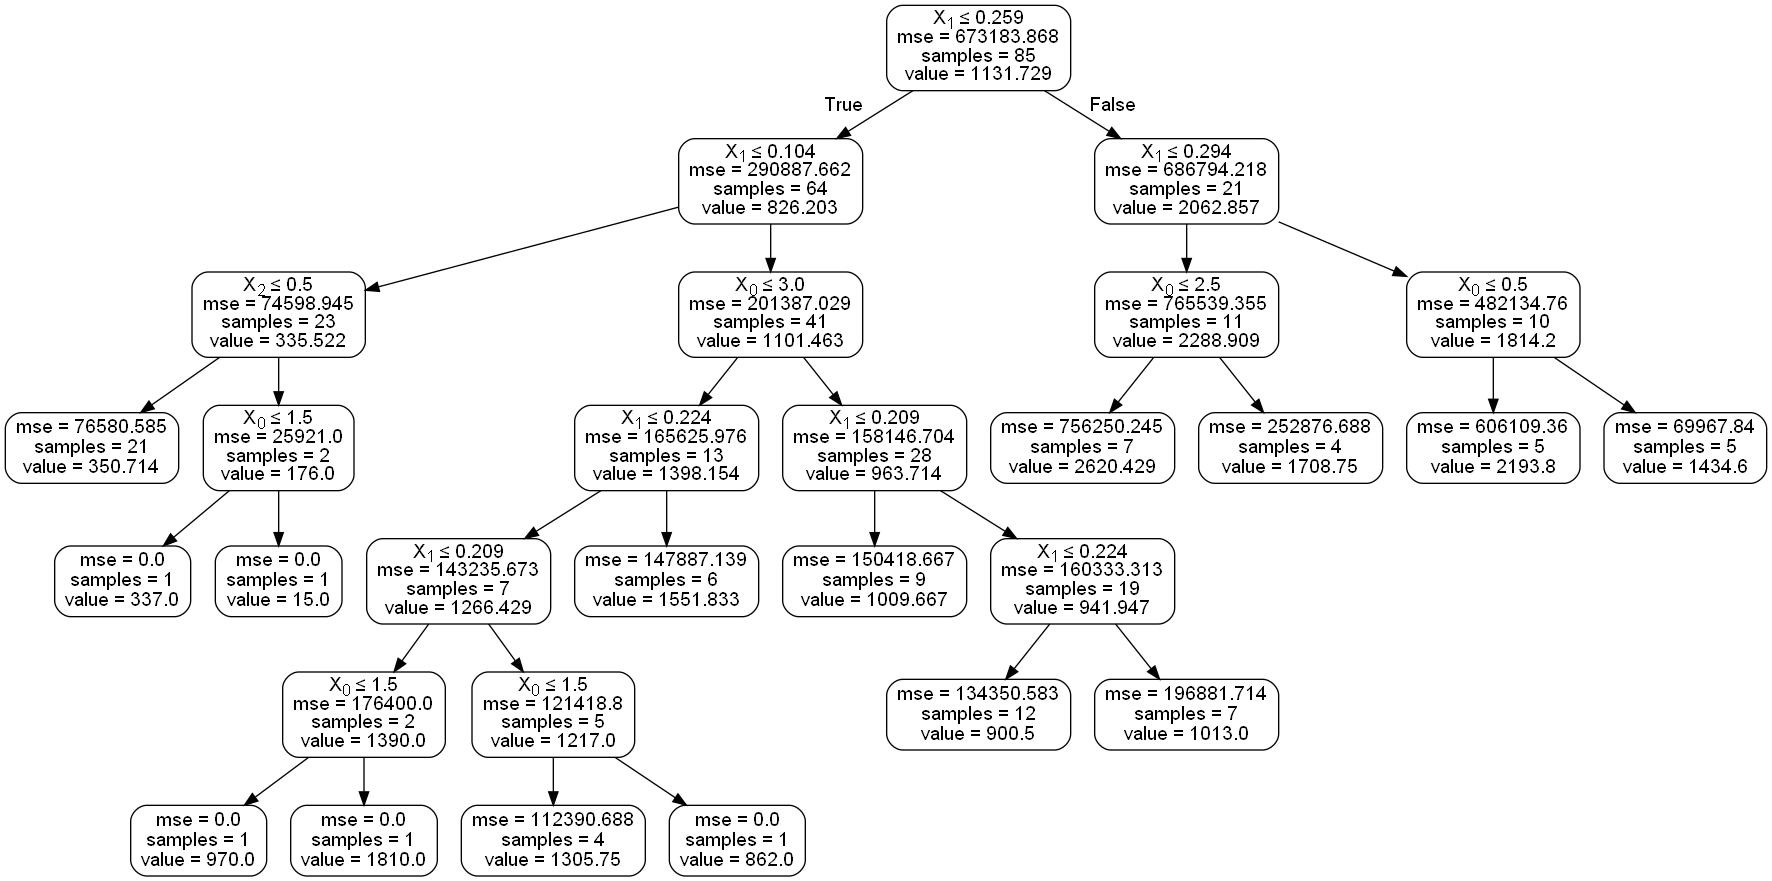

In [22]:
Image(graph.create_png())

In [29]:
treeStep1 = trainingDataFeatures.loc[trainingDataFeatures.PRO_PERCENT > 0.259]

In [30]:
treeStep2 = treeStep1.loc[treeStep1.PRO_PERCENT > 0.294]

In [31]:
treeStep3 = treeStep2.loc[treeStep2.HCLUS > 0.5]

In [32]:
treeStep3.index

Int64Index([77, 78, 79, 80, 81], dtype='int64')

In [33]:
trainingDataLabel.loc[treeStep3.index].QTY.mean()

1434.6